In [21]:
import pandas as pd
import seaborn as sns
import warnings  # To suppress some warnings
import matplotlib.pyplot as plt
import numpy as np

# Suppress the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")


sns.set_style("whitegrid")

In [3]:
df = pd.read_csv("data/raw/train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

## Columns with NaNs

Quite a few columns contain NaNs data. In particular "Occupation", "Previous Clains" and "Credit Score" which can be a bit challenging to impute. We will see if they are correlated to the target.

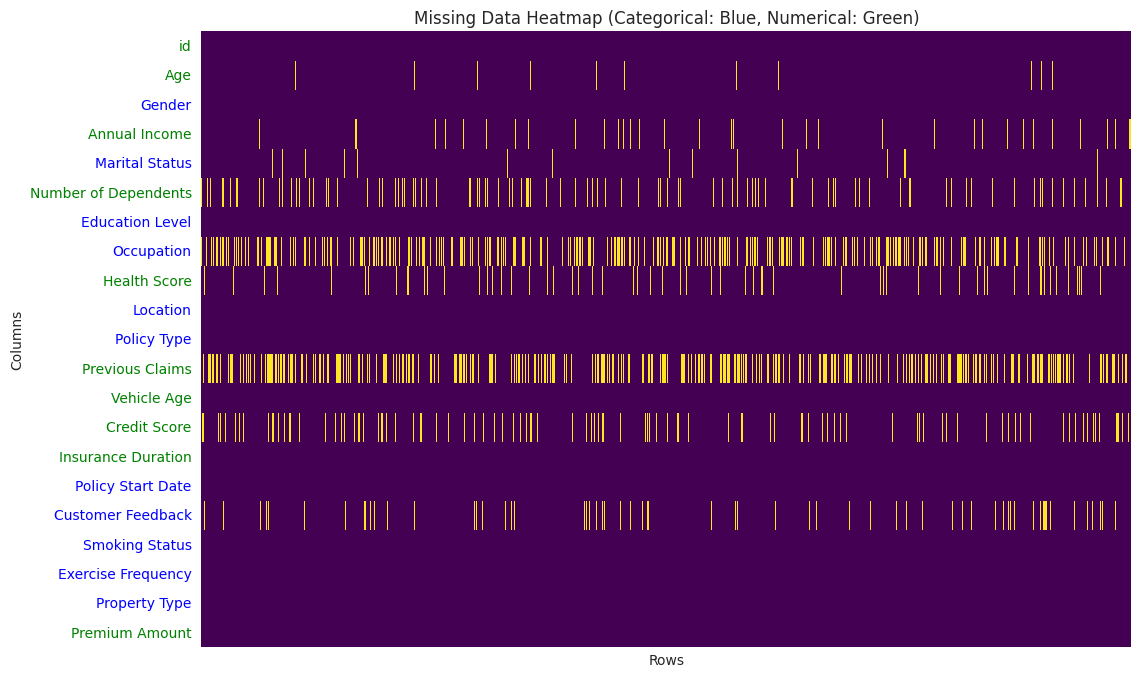

In [4]:
# Determine column types
categorical_columns = df.select_dtypes(include=["object", "category"]).columns
numerical_columns = df.select_dtypes(include=["number"]).columns
plt.figure(figsize=(12, 8))
ax = sns.heatmap(df.isnull().T, cbar=False, cmap="viridis", xticklabels=False)
# Color the y-axis labels
for label in ax.get_yticklabels():
    if label.get_text() in categorical_columns:
        label.set_color("blue")
    elif label.get_text() in numerical_columns:
        label.set_color("green")

# Set labels and title
plt.title("Missing Data Heatmap (Categorical: Blue, Numerical: Green)")
plt.ylabel("Columns")
plt.xlabel("Rows")
plt.show()

## Categorical data

Categorical are quite uniformly distributed. **There is no categorical columns with high cardinality.**

"Policy Start Date" should not have been classified as categorical in the plot above. We should convert it to ordinal but this is not an issue.

<Axes: xlabel='Occupation', ylabel='count'>

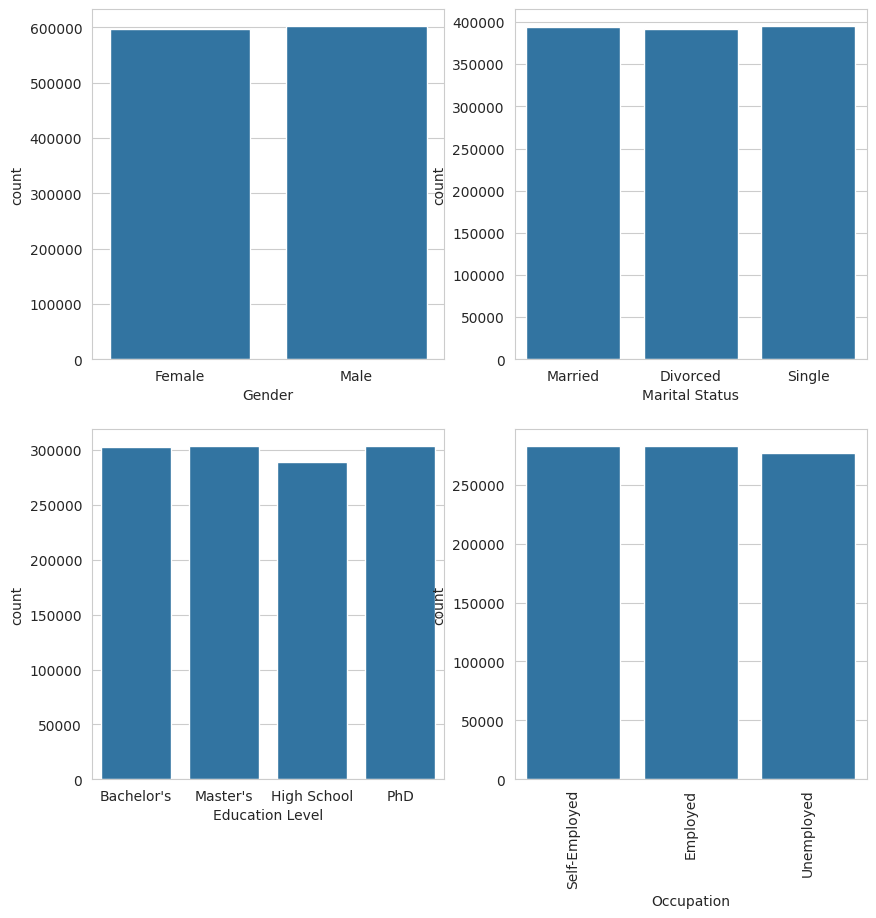

In [5]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(10, 10))

plt.xticks(rotation=90)
sns.countplot(df, x="Gender", ax=ax1)
sns.countplot(df, x="Marital Status", ax=ax2)
sns.countplot(df, x="Education Level", ax=ax3)
sns.countplot(df, x="Occupation", ax=ax4)

<Axes: xlabel='Smoking Status', ylabel='count'>

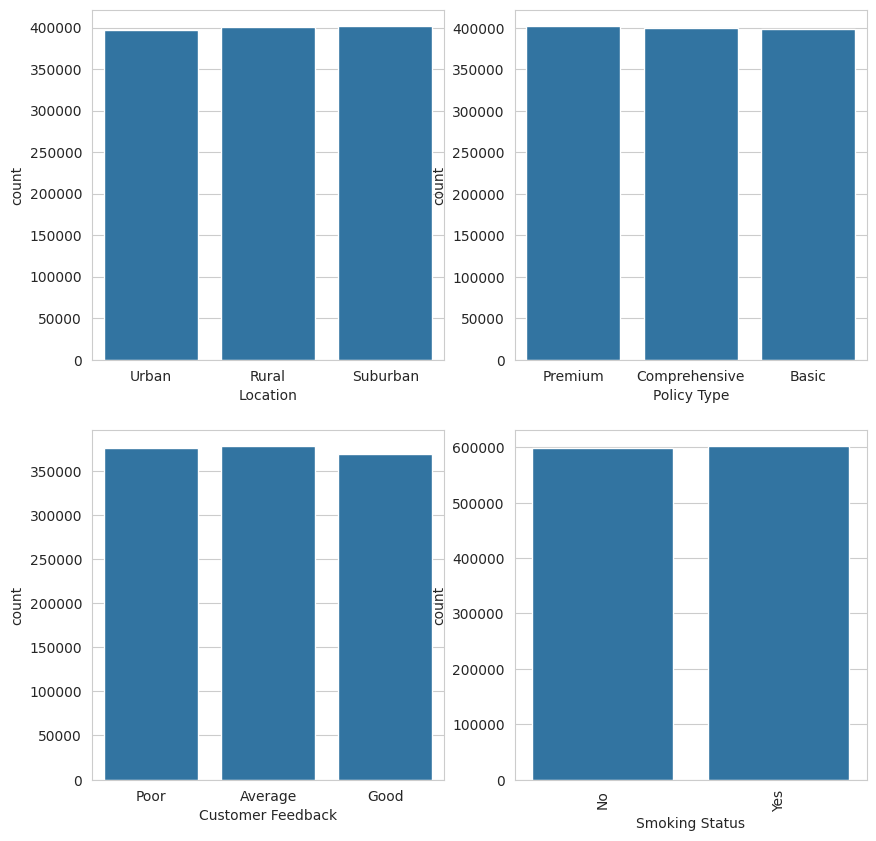

In [8]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(10, 10))

plt.xticks(rotation=90)
sns.countplot(df, x="Location", ax=ax1)
sns.countplot(df, x="Policy Type", ax=ax2)
sns.countplot(df, x="Customer Feedback", ax=ax3)
sns.countplot(df, x="Smoking Status", ax=ax4)

<Axes: xlabel='Property Type', ylabel='count'>

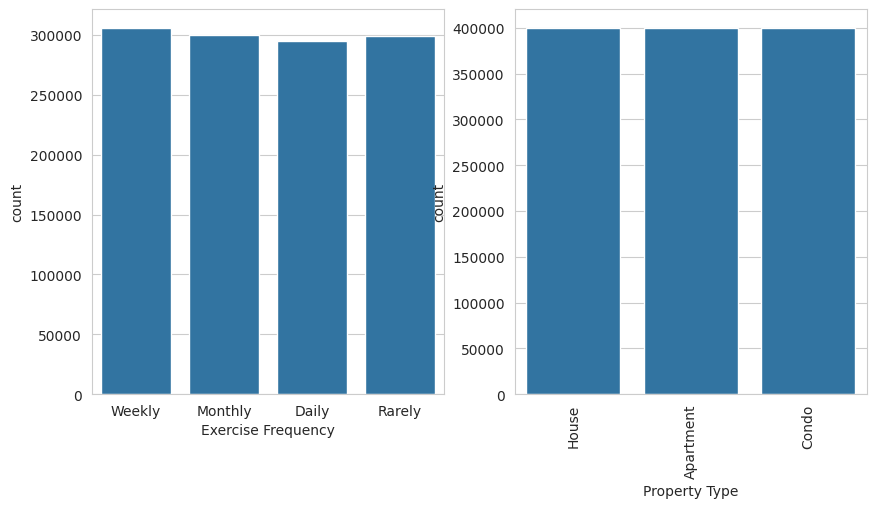

In [12]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))

plt.xticks(rotation=90)
sns.countplot(df, x="Exercise Frequency", ax=ax1)
sns.countplot(df, x="Property Type", ax=ax2)

## Numerical data

Most relevant columns seem to be "Annual Income", "Credit Score", "Previous Claims", "Credit Score" as they show the highest correlation with "Premium Amount" (the target).

"Previous Claims" is positively correlated to "Premium Amount", which is intuitive because insurance companies increase the premium for "risky" clients who will claim reimbursments more often.

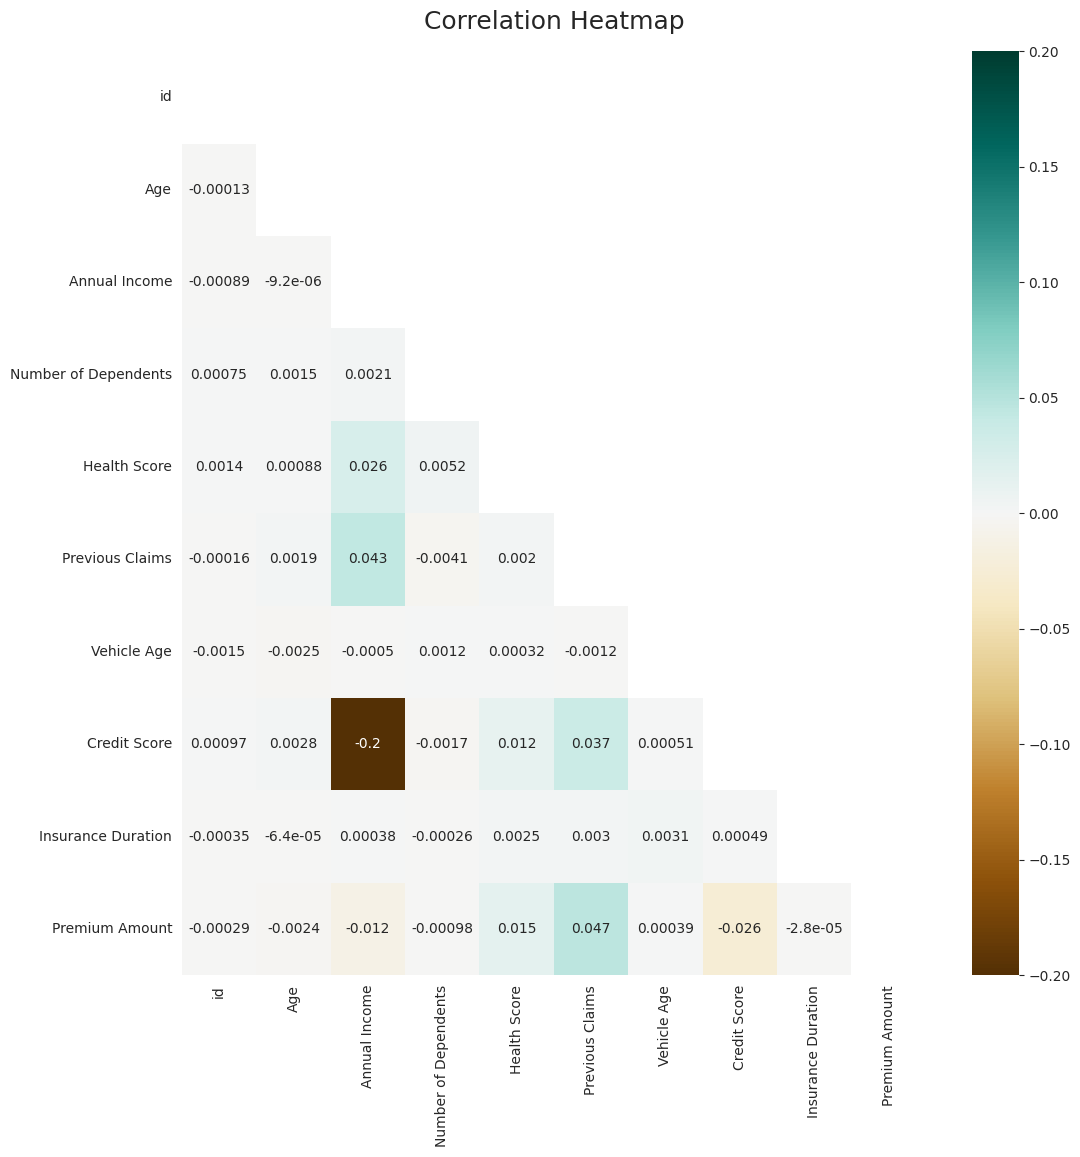

In [ ]:
plt.figure(figsize=(12, 12))
corr = df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr))
ax = sns.heatmap(corr, mask=mask, cmap="BrBG", annot=True, vmin=-0.2, vmax=0.2)
ax.grid(False)
ax.set_title("Correlation Heatmap", fontdict={"fontsize": 18}, pad=16)
plt.show()

We confirm this observation in the plot below.

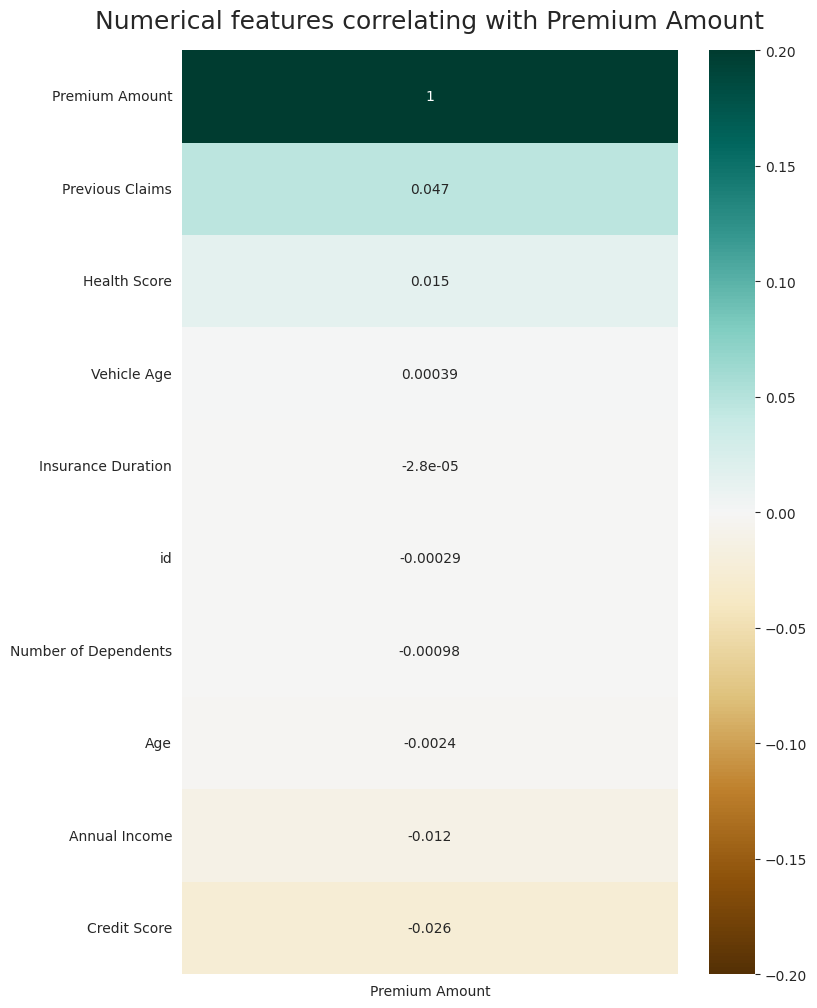

In [ ]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(
    corr[["Premium Amount"]].sort_values(by="Premium Amount", ascending=False),
    vmin=-0.2,
    vmax=0.2,
    annot=True,
    cmap="BrBG",
)
heatmap.set_title(
    "Numerical features correlating with Premium Amount", fontdict={"fontsize": 18}, pad=16
);